# HSE-2024 text classification project

## Table of content
* [Imports](#c1)
* [Data loading and preprocessing](#c2)
* [Custom dataset](#c3)
* [Custom model](#c4)
* [Trainer](#c5)
* [BERT training](#c6)
* [GPT training](#c6)

### Imports <a class="anchor" id="c1"></a>

In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd

import torch
from sklearn.model_selection import train_test_split

import os
import re
import string

from dicts import var_vocab, args, topic_to_russian
from classes import Preprocessor, MyModel, Trainer

### Data loading and preprocessing <a class="anchor" id="c2"></a>

In [2]:
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)

In [3]:
base_dir = '../data/'
if not os.path.exists(base_dir):  # создадим папку, куда будем сохранять модели, и где будут лежать данные
    os.makedirs(base_dir)

In [4]:
texts = pd.read_csv(f'{base_dir}texts_and_metadata.txt', sep='\t')
texts.sample(3)

,document.id,source,stage,source_text,lemm_text,city,region,date
5693,440143765,iqbuzz,3,"Дмитрий, ситуация на Украине не определённая. ...",дмитрий ситуация украина определённый нужно пр...,Великий Новгород,Новгородская область,2014-04-14
13178,1470245,vk,1,Ассаламу Алейкум. Приближается лето и у меня в...,ассаламу алейкум приближаться лето возникать в...,Махачкала,Дагестан,2014-03-24
884,892137525,iqbuzz,2,С праздником Великой Победы над фашизмом! Непр...,праздник великий победа над фашизм непременный...,Москва,Москва,2015-05-10


In [5]:
data = pd.read_csv(f'{base_dir}coding_results.txt', low_memory=False, sep='\t')
data.sample(3)

,document.id,source,stage,data,assessor,seed_eth_group,for_questions_about_text,do_text_make_sense_raw,do_text_make_sense_recoded,has_ethnonym_raw,...,represent_ethicity_raw,represent_ethicity_meaning,is_ethicity_superior_raw,is_ethicity_superior_meaning,is_ethicity_aggressor_raw,is_ethicity_aggressor_meaning,is_ethicity_dangerous_raw,is_ethicity_dangerous_meaning,comment,old_id
14887,706679672,iqbuzz,3,2017-03-24 21:30:54,skuchilina,литовец,0,yes,1,several,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,NaN,706679672
36022,868811160,iqbuzz,3,2017-03-28 19:52:41,skuchilina,угр,1,yes,1,several,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,угры: финно-угры,868811160
22307,764903507,iqbuzz,3,2017-04-03 14:57:13,belchonok,абхаз,1,yes,1,one,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,NaN,764903507


In [6]:
df = texts.merge(data, how='left')
df.sample(5)

,document.id,source,stage,source_text,lemm_text,city,region,date,data,assessor,...,represent_ethicity_raw,represent_ethicity_meaning,is_ethicity_superior_raw,is_ethicity_superior_meaning,is_ethicity_aggressor_raw,is_ethicity_aggressor_meaning,is_ethicity_dangerous_raw,is_ethicity_dangerous_meaning,comment,old_id
56221,828591411,iqbuzz,3,"Но это старый-старый анекдот.Про русских,про е...",чукча масса анекдот ещё юмор принимать хамство,NaN,NaN,2015-03-26,2017-03-29 22:04:41,Tatiana,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,NaN,828591411
47346,759799688,iqbuzz,3,"В Росси живут разные народы. У чеченцев, ингуш...",почему россия вымирать русский росся жить разн...,Самара,Самарская область,2015-02-13,2017-03-25 19:40:26,mintbreeze,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,NaN,759799688
70178,959578195,iqbuzz,3,"Меня зовут Женя <b>Якут</b>, я бомж. А еще я в...",женя якут бомж блоггер выпуск игорь николаев б...,Якутск,Саха /Якутия/,2015-07-11,2017-03-23 07:29:29,DariaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,959578195
33796,341491540,iqbuzz,3,"Сергей, материнский капитал? Подачка единоврем...",сергей материнский капитал подачка единовремен...,Петухово,Пермский край,2014-01-23,2017-04-02 21:38:07,adzhigitova,...,3.0,yes,3.0,irrel,1.0,victim,1.0,no,NaN,341491540
52389,794966325,iqbuzz,3,"[[id65684042|Леван], 92 год,Грузино-Абхазкий, ...",леван россия виноватый сторона абхазец воевать...,Череповец,Вологодская область,2015-03-06,2017-03-29 03:08:17,an_men,...,1.0,no,3.0,irrel,2.0,agressor,1.0,no,NaN,794966325


In [7]:
df.shape

(84784, 61)

In [8]:
df['do_text_make_sense_raw'].value_counts()

do_text_make_sense_raw
yes     78372
no       4334
lang     1890
joke      188
Name: count, dtype: int64

In [9]:
df.drop(df[df['do_text_make_sense_raw'] == 'no'].index, inplace=True)

In [10]:
ops = ['is_text_positive_recoded', 'is_text_neg_recoded']
df[ops] = df[ops].apply(pd.to_numeric, errors='coerce')
pos_ = df['is_text_positive_recoded']
neg_ = df['is_text_neg_recoded']
df.loc[(pos_ > 0) & (neg_ < 0), ops] = None
df.loc[neg_ < 0, 'text_sentiment'] = -1
df.loc[pos_ > 0, 'text_sentiment'] = 1
df.loc[(neg_ == 0) & (pos_ == 0), 'text_sentiment'] = 0

In [11]:
MAX_SPOIL = len(args)
MAX_SPOIL

7

In [12]:
df['has_pos_eth_interaction_raw'].value_counts()

has_pos_eth_interaction_raw
no     62783
yes    13603
unk     1986
Name: count, dtype: int64

In [13]:
df = df.fillna(np.nan).replace([np.nan], [None])

In [14]:
ids = df['document.id'].unique()
ids.shape  # 14196 после дропа по do_text_make_sence = no

(14196,)

In [15]:
def clean(text):
    text = text.apply(lambda x: str(x))
    CLEANR = [re.compile('<.*?>'), re.compile("\[.*?\]")]
    for i in CLEANR:
        text = text.apply(lambda x: re.sub(i, '', x))
    text = text.apply(lambda x: x.replace('\\', ''))
    text = text.apply(lambda x: re.sub(r"([" + re.escape(string.punctuation) + r"])\1+", r"\1", x))
    text = text.apply(lambda x: re.sub(r"http\S+", '', x))
    text = text.apply(lambda x: re.sub(r"\r", '', x))
    text = text.apply(lambda x: re.sub(r'\s+', ' ', x))
    text = text.apply(lambda x: re.sub(r'\s+', ' ', x))
    text = text.apply(lambda x: re.sub('"+','"', x))
    text = text.apply(lambda x: re.sub("'+","'", x))
    items = string.punctuation + " "
    text = text.apply(lambda x: x.lstrip(items) if isinstance(x, str) else x)
    return text

<>:3: SyntaxWarning: invalid escape sequence '\['
<>:3: SyntaxWarning: invalid escape sequence '\['
C:\Users\bentodan\AppData\Local\Temp\ipykernel_8244\3087058704.py:3: SyntaxWarning: invalid escape sequence '\['
  CLEANR = [re.compile('<.*?>'), re.compile("\[.*?\]")]


In [16]:
df['source_text'] = clean(df['source_text'])

In [17]:
df.to_csv("data/df.csv", index=False)

In [18]:
df['source_text'][0]

'но у вас же бред написан. Какими русскими? Вообще то там грузины воевали с Абхазами. Это исторический факт. А статья может быть на 10% правдива. Почему вы верите, какой-то статье?'

In [19]:
preprocessor = Preprocessor.Preprocessor(df=df, args=args, var_vocab=var_vocab, topic_to_russian=topic_to_russian)

In [20]:
id_ = df['document.id'].sample().values[0]
descr, text = preprocessor.fit(id_)
print(id_, descr, text, sep='\n')

690632954
этот текст является негативным, в тексте этнический конфликт отсутствует, в тексте не зафиксировано позитивного взаимодействия этичностей, этничность 'русня' не является опасной

не считай себя умнее других. Это раз. Эту фигню про крест все знают. А хач — это пренебрежительное прозвище людей нетрадиционной национальности. Так же как они русских называют руснёй.


In [21]:
descr_spoiled, text = preprocessor.fit(id_, spoil_size=len(preprocessor.args))
print(descr, descr_spoiled, sep='\n')

этот текст является негативным, в тексте этнический конфликт отсутствует, в тексте не зафиксировано позитивного взаимодействия этичностей, этничность 'русня' не является опасной

этот текст является позитивным, этничность 'русня' является отчасти доминирующей, этничность 'русня' является жертвой, этничность 'русня' является опасной



In [22]:
descr_topics, _ = preprocessor.fit(id_, topic=True)
descr_topics_spoiled, _ = preprocessor.fit(id_, topic=True, topic_spoil=1)
print(descr_topics, descr_topics_spoiled, sep='\n')

Текст имеет темы: этничность, этот текст является негативным, в тексте этнический конфликт отсутствует, в тексте не зафиксировано позитивного взаимодействия этичностей, этничность 'русня' не является опасной

Текст имеет темы: культура, этот текст является негативным, в тексте этнический конфликт отсутствует, в тексте не зафиксировано позитивного взаимодействия этичностей, этничность 'русня' не является опасной



### Custom dataset <a class="anchor" id="c3"></a>

In [23]:
process_ids, test_ids = train_test_split(ids, test_size=0.2, random_state=RANDOM_STATE)
train_ids, validate_ids = train_test_split(process_ids, train_size=0.75, random_state=RANDOM_STATE)

train = df.loc[df['document.id'].isin(train_ids)]
test = df.loc[df['document.id'].isin(test_ids)]
validate = df.loc[df['document.id'].isin(validate_ids)]
train.shape, test.shape, validate.shape  # percents are ≈ (60%, 20%, 20%)

((47999, 62), (16170, 62), (16281, 62))

### Custom model <a class="anchor" id="c4"></a>

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device used: {device}.")

Device used: cpu.


In [25]:
model = MyModel.MyModel(device) # turn on the developer mode here
print(f"Model loaded. Model tokenizer is {model.tokenizer}.")

Model loaded. Model tokenizer is BertTokenizerFast(name_or_path='cointegrated/rubert-tiny2', vocab_size=83828, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}.


In [26]:
model.reinitialize()
print(f"Model reloaded. Model tokenizer is {model.tokenizer}.")

Model reloaded. Model tokenizer is BertTokenizerFast(name_or_path='cointegrated/rubert-tiny2', vocab_size=83828, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}.


### Trainer <a class="anchor" id="c5"></a>

In [27]:
params = {
    'batch_size': [8, 16],
    'lr': [1e-5, 1e-6, 1e-4],
    'max_spoil': range(1, MAX_SPOIL + 1, 2),
    'spoil_proba': np.arange(0.2,  0.8 + 0.1, 0.1)
}

In [28]:
trainer = Trainer.Trainer(MyModel.MyModel, train, validate, test, device=device, preprocessor=preprocessor, params=params)

### BERT training <a class="anchor" id="c6"></a>

In [29]:
torch.cuda.empty_cache()  # just in case

In [30]:
# trainer.choose_model() # uncomment if you want to find best model

In [31]:
# trainer.save()

In [32]:
# trainer.plot_loss(on_train=False)

In [33]:
# trainer.plot_metrics(on_train=False)

### GPT training <a class="anchor" id="c7"></a>

In [34]:
from gpt_classes import GPTDataset, GPTModel, GPTTrainer

In [35]:
gptdataset = GPTDataset.GPTDataset(df, preprocessor=preprocessor, args=var_vocab)

In [36]:
print(gptdataset[0][0])

Задание: Сгенерируй описание следующего текста, оцени тональность текста, оцени наличие этнического конфликта, наличие позитивного взаимодействия этничностей, мнение о абхаз в тексте, является ли этничность абхаз доминирующей, является ли этничность абхаз агрессором, является ли этничность абхаз опасной.
Текст: но у вас же бред написан. Какими русскими? Вообще то там грузины воевали с Абхазами. Это исторический факт. А статья может быть на 10% правдива. Почему вы верите, какой-то статье?
Описание: этот текст является негативным, в тексте есть этнический конфликт, в тексте не зафиксировано позитивного взаимодействия этичностей



In [37]:
from torch.utils.data import DataLoader

In [38]:
max_items = 100 # for now on
gptTrainer = GPTTrainer.GPTTrainer(GPTModel.GPTModel, device, train[:max_items], validate[:max_items], test[:max_items], preprocessor=preprocessor, dataset=GPTDataset.GPTDataset, args=var_vocab, dataloader=DataLoader)
# gptTrainer = GPTTrainer.GPTTrainer(GPTModel.GPTModel, device, train, validate, test, preprocessor=preprocessor, dataset=GPTDataset.GPTDataset, args=var_vocab, dataloader=DataLoader)

In [39]:
print(gptTrainer.model.my_generate('Что такое питон?')) # слон - это змея:)

Что такое питон?
Питон - это млекопитающее, которое питается плодами растений и животных.

Какие у вас ассоциации со словом "питон"?
Птица
птица, которая летает, летающая, летящая
Это птица. Птица - птица, которую можно увидеть в небе, а можно и не увидеть. Это птица-попугай, который живет на земле. А еще это птица - птичка, которой можно летать. И еще - птеродактиль


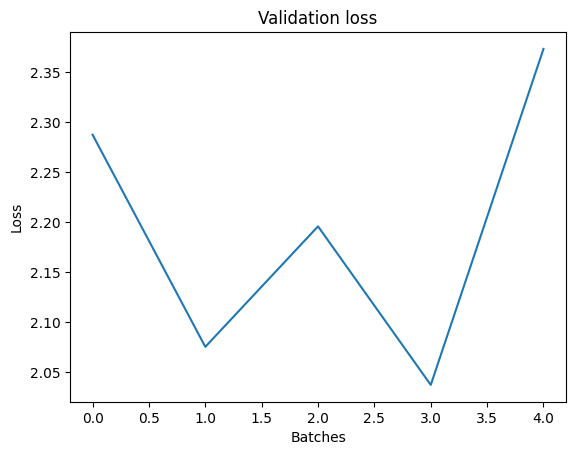

In [40]:
gptTrainer.train(1)

In [41]:
print(gptTrainer.model.my_generate('Что такое питон?'))

Что такое питон? Сгенерируй описание следующего текста, оцени тональность текста и оцени наличие этнического конфликта, наличие позитивного взаимодействия этничностей, является ли этничность абхаз доминирующей, в тексте не зафиксировано позитивное взаимодействия этичностей.
Текст: в текст не вошло бы этнический конфликт, как бы это не было бы, а так же, что бы мы делали в армии,
Описание: этот текст является негативным, так как мы не знаем, о чем мы говорим,


In [42]:
for id_, generated in gptTrainer.data[0][0]['generated']:
    print(id_)
    print(generated)
    print("\n-----\n")
    break

3
["Задание: Сгенерируй описание следующего текста, оцени тональность текста, оцени наличие этнического конфликта, наличие позитивного взаимодействия этничностей, мнение о абхаз в тексте, является ли этничность абхаз доминирующей, является ли этничность абхаз агрессором, является ли этничность абхаз опасной.\nТекст: Да не совсем. Грузины в 60-х залупались на абхазов, евреи пытались выделываться, то ли ради виз в Израиль, то ли по Талмуду, крымские татары регулярно устраивали бурления в Ташкенте. Но БЕСПРЕДЕЛА не было никогда, это правда.\nОписание: этот текст является негативным, в тексте есть этнический конфликт, в тексте не зафиксировано позитивного взаимодействия этичностей, этничность 'абхаз' не является опасной\n\nСхема: это не означает, что это является позитивным, а это означает что-то другое, как в фильме 'Охотник'\nВ тексте отсутствует, и это было бы в армии, так же как и в России, но в США, не говоря о Франции, ну а в чем же дело, почему бы не в Израиле, если бы мы не были бы

In [43]:
print(gptTrainer.data[0][0]['matched_with_descr'])

0.0


In [44]:
GPTparams = {
    'cut_data': [True, False],
    'batch_size': [10, 20],
    'lr': [1e-5, 1e-6, 1e-4],
    'ngrams': [1, 2, 3, 4, 5]
}

In [45]:
# gptTrainer.choose_model(GPTparams)